# Tutorial 1
In this tutoral we will learn how to run a simple periodic SCC-DFTB  calculation using the DFTB+ package. We will use Slater-Koster tables and repulsive potentials from the GFN-xTB paramerization  

In [1]:
#@title Create environment and install required software
# Conda is uninstalled every time you rehash yuor environment...
#!conda --version
#If !conda --version returns no results, install conda with :
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:14
🔁 Restarting kernel...


In [2]:
%%capture
!conda install -c conda-forge mamba dftbplus
!conda install -c conda-forge dftbplus-tools
!conda install -c conda-forge ase
!conda install -c conda-forge py3dmol


# THE FUN STARTS HERE!
# SETTING UP A DFTB+ CALCULATION

First we have a look at the main input file for dftb+ the `dftb_in.hsd` file. A complete documention of all key-words and features can be found here: https://dftbplus.org/documentation

In the box below we create a rather minimalistic input and save it to file.

There are a few system specific setting that we need to specify correctly in order for the calculation to work.

1. There are a few places in the input that contains atomic specific input. These must not be in conflict with the system that we like to simulate.

The most important is this block:
```
MaxAngularMomentum = {
      H = s # <--- IMPORTANT! WE NEED TP SPECIFY THE MAXIMUM ANGULAR MOMENT FOR EACH ATOM WE CONSIDER
   }
```
If we perform any advanced and atom specific anaylysis these block also need to be controlled. E.g.:

```
Analysis = { # THE "Analysis" BLOCK SPECIFIES WHAT EXTRA INFORMATION TO EXTRACT AND PRINT OUT
  WriteEigenvectors = Yes
  ProjectStates={
    Region = {
      Atoms = H
      ShellResolved = Yes
      Label = "dos"
    }
  }
}
```

2. In addition there are some unique input in case we use periodic boundary conditions. Namely, the specification of k-points in a block looking like this:

```
   KPointsAndWeights = SupercellFolding {
      1 0 0
      0 1 0
      0 0 1
      0.0 0.0 0.0
   }
```

This block must be present for periodic systems but must NOT be present if we consider a non-peroidic system.

### The example file below sets up a simultation for a periodic system consiting entirely of hydrogen atoms. (Very useful if we like to run a simulation of a hydrogen chain.)


In [8]:
#THE MAIN INPUT FILE FOR DFTB+ CODE IS dftb_in.hsd.
#THE CODE BELOW SHOW HOW TO WRITE SUCH A FILE.
dftb_in='''
Geometry = GenFormat {
    <<< "in.gen" #The file containing the geometry of the system
}

Driver = ConjugateGradient{ #THE "Driver" BLOCK CONTROLS GEOMETRY OPTIMIZATION
   MaxForceComponent = 0.0001
   MaxSteps = 0
   }

Hamiltonian = xTB{ #THE "Hamiltonian" BLOCK GIVE SETTING FOR THE ELECTRONICS
   Method = "GFN1-xTB"
   KPointsAndWeights = SupercellFolding {
      1 0 0
      0 1 0
      0 0 1
      0.0 0.0 0.0
   }
   #MaxAngularMomentum = {
   #   H = s # <--- IMPORTANT! WE NEED TP SPECIFY THE MAXIMUM ANGULAR MOMENT FOR EACH ATOM WE CONSIDER
   # }
   SCC = Yes
   SCCTolerance = 1e-08 # SelfConsistentField convergence criterium.
   #SlaterKosterFiles = Type2FileNames{
   #   Prefix = ./mio-1-1/
   #   Separator = "-"
   #   Suffix = ".skf"
   #   }
   }
Options {
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}
Analysis = { # THE "Analysis" BLOCK SPECIFIES WHAT EXTRA INFORMATION TO EXTRACT AND PRINT OUT
  WriteEigenvectors = Yes
  ProjectStates={
    Region = {
      Atoms = H
      ShellResolved = Yes
      Label = "dos"
    }
  }
}
ParserOptions {
   IgnoreUnprocessedNodes = Yes
}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

# BUILDING A HYDROGEN CHAIN IN ASE AND EXPORT IT TO DFTB+-FORMAT
The box below demonstrates how we can build a hydrogen chain in ASE and export it to a file called `in.gen`. Note that this filename must match the following block in the `dftb_in.hsd` file:

```
Geometry = GenFormat {
    <<< "in.gen" #The file containing the geometry of the system
}
```


In [9]:
from ase.build import bulk
from ase.io import read,write
from ase import Atoms
import numpy as np
d=2.0 # Distance between H
N=16  # Number of H

pos=[]
for i in range(N):
  pos.append([0,0,i])

cell=[[3*N,0.,0.],[0.,3*N,0.],[0.,0.,N]]
pos=np.array(pos)
cell=np.array(cell)

pos=pos*d
cell=cell*d

atoms=Atoms(f'H{N}', positions=pos,cell=cell,pbc=[True,True,True])
write("in.gen",atoms)

# RUN DFTB+
Nex box simply executes dftb+. Remove the `> std.out` to see the output flowing on the screen.

In [10]:
!dftb+ > std.out

# PREPARE FOR POST-PROCESSING
We will make use of the `dp_tools` package to analyse and visualize electronic structure properties.

More details and examples can be found here.

https://dftbplus-recipes.readthedocs.io/en/latest/basics/bandstruct.html



# MAKE A BANDPLOT

In order to make a band-plot we make use of the k-point block in dftb+:

```
   KPointsAndWeights = SupercellFolding {
      1 0 0
      0 1 0
      0 0 128  # <-- NOTE: WE INCREASE THE NUMBER OF K-POINTS ALONG THE CHAIN
      0.0 0.0 0.0
   }
```

This block tells DFTB+ to use one k-point along the x, one along y, and 128 along z. Note that our hydrogen chain is along z.

When increasing the number of k-points along the chain we make use of Bloch's teorem. This allow us to accurately describe an infinite chain with only one H atom in our cell! In the limit of an infinite amount of k-points the result is exact, but since the bands are smooth we can often get converged results with not too many of them.


2


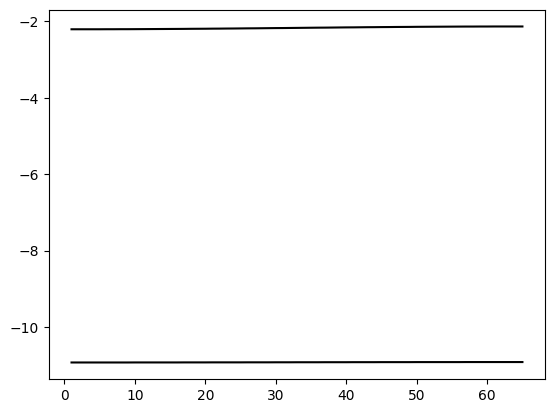

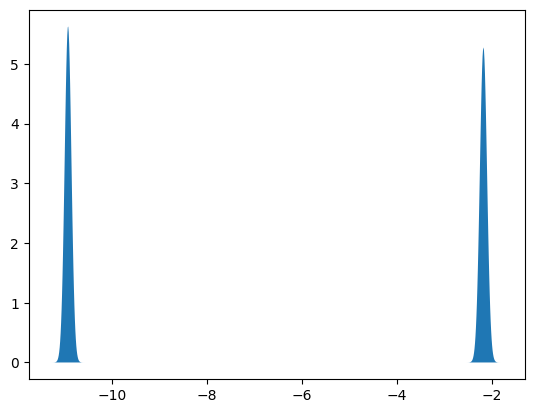

In [16]:
d=5.0 # Distance between H
N=1  # Number of H

pos=[]
for i in range(N):
  pos.append([0,0,i])

cell=[[3*N,0.,0.],[0.,3*N,0.],[0.,0.,N]]
pos=np.array(pos)
cell=np.array(cell)

pos=pos*d
cell=cell*d

atoms=Atoms(f'H{N}', positions=pos,cell=cell,pbc=[True,True,True])
write("in.gen",atoms)


dftb_in='''
Geometry = GenFormat {
    <<< "in.gen"
}

Driver = ConjugateGradient{
   MaxForceComponent = 0.0001
   MaxSteps = 0
   }
Hamiltonian = xTB{
   Method= "GFN1-xTB"
   KPointsAndWeights = SupercellFolding {
      1 0 0
      0 1 0
      0 0 128
      0.0 0.0 0.0
   }
   SCC = Yes
   SCCTolerance = 1e-08
   }
Options {
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}
Analysis = {
  WriteEigenvectors = Yes
  ProjectStates={
    Region = {
      Atoms = H
      ShellResolved = Yes
      Label = "dos"
    }
  }
}
ParserOptions {
   IgnoreUnprocessedNodes = Yes
}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

!dftb+ > std.out
!dp_bands band.out band


#PLOTTING BANDSTRUCUTRE
import numpy as np
import matplotlib.pyplot as plt

band=np.loadtxt("band_tot.dat")
n_bands=np.shape(band)[1]-1
print(n_bands)
for i in range(n_bands):
  plt.plot(band[:,0],band[:,i+1],color="black")
plt.show()


#PLOTTING DENSITY OF STATES
!dp_dos band.out dos.dat
dos_tot=np.loadtxt("dos.dat")
plt.fill_between(dos_tot[:,0],dos_tot[:,1],label="d",alpha=1.0)
plt.show()

Before proceeding to more advanced example below you should answer the following questions:

1. What is the connection between the band diagram and the DOS plot?
2. Consider the x-axis in the band diagram plot obtained using one atom in the cell (N=1). In the plot, the x-values covers the range from zero to the number of k-points used. What would be the proper range along the axis? In other words, how would you label the first and the last k-point?
3. Compare band diagrams for the one atom case when using different seperation between the H atoms (e.g. for d=2.0 and d=3.0). What happens and how can we uderstand it in simple terms?
4. Compare the band diagrams obtained using one atom in the cell (N=1) with the bandstructure obtained when using two atoms in the cell (N=2). How are the two related?

Extra task: Repeat the proceedure for a two dimensional square lattice of H atoms.

####################################
# ADVANCED PART (LACKS SOME DESCRIPTION)
####################################

The concepts from the hydrogen chain can be generalized to at-least three dimensions. The advanced example considers metallic gold. Then the xTB potential is not the best. Instead we use optimized potentials fro Au which we can download from dftb.org.

In [17]:
#@title Downloading parameter sets
%%capture
!wget https://dftb.org/fileadmin/DFTB/public/slako/auorg/auorg-1-1.tar.xz

In [25]:
#@title Unpacking the parameter sets
!conda install -c conda-forge xz
!xz -d -v auorg-1-1.tar.xz
!tar xf auorg-1-1.tar

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.7.1
    latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

auorg-1-1.tar.xz (1/1)
xz: auorg-1-1.tar.xz: No such file or directory


# SETTING UP A DFTB+ CALCULATION for SK-files

First we have a look at the main input file for dftb+ the `dftb_in.hsd` file. A complete documention of all key-words and features can be found here: https://dftbplus.org/documentation

In the box below we create a rather minimalistic input and save it to file.

There are a few system specific setting that we need to specify correctly in order for the calculation to work.

1. There are a few places in the input that contains atomic specific input. These must not be in conflict with the system that we like to simulate.

The most important is this block:
```
MaxAngularMomentum = {
      H = s # <--- IMPORTANT! WE NEED TP SPECIFY THE MAXIMUM ANGULAR MOMENT FOR EACH ATOM WE CONSIDER
   }
```
If we perform any advanced and atom specific anaylysis these block also need to be controlled. E.g.:

```
Analysis = { # THE "Analysis" BLOCK SPECIFIES WHAT EXTRA INFORMATION TO EXTRACT AND PRINT OUT
  WriteEigenvectors = Yes
  ProjectStates={
    Region = {
      Atoms = H
      ShellResolved = Yes
      Label = "dos"
    }
  }
}
```

2. In addition there are some unique input in case we use periodic boundary conditions. Namely, the specification of k-points in a block looking like this:

```
   KPointsAndWeights = SupercellFolding {
      1 0 0
      0 1 0
      0 0 1
      0.0 0.0 0.0
   }
```

This block must be present for periodic systems but must NOT be present if we consider a non-peroidic system.


In [26]:
from ase.build import bulk
from ase.io import read,write
from ase import Atoms
import numpy as np

atoms=bulk('Au','fcc')

write("in.gen",atoms)

dftb_in='''
Geometry = GenFormat {
    <<< "in.gen"
}

Driver = ConjugateGradient{
   MaxForceComponent = 0.0001
   MaxSteps = 0
   }
Hamiltonian = DFTB{
   KPointsAndWeights = SupercellFolding {
      16 0 0
      0 16 0
      0 0 16
      0.25 0.25 0.25
   }
   MaxAngularMomentum = {
      Au = d
   }
   SCC = Yes
   SCCTolerance = 1e-08
   SlaterKosterFiles = Type2FileNames{
      Prefix = ./auorg-1-1/
      Separator = "-"
      Suffix = ".skf"
      }
   }
Options {
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}
Analysis = {
  WriteEigenvectors = Yes
  ProjectStates={
    Region = {
      Atoms = Au
      ShellResolved = Yes
      Label = "dos_Au"
    }
  }
}
ParserOptions {
   IgnoreUnprocessedNodes = Yes
}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

### Here we run DFTB+ and produce the files projected DOS files for plotting.

In [27]:
!dftb+
!dp_dos band.out dos.dat
!dp_dos -w dos_Au.1.out dos_s.dat
!dp_dos -w dos_Au.2.out dos_p.dat
!dp_dos -w dos_Au.3.out dos_d.dat

Streaming output truncated to the last 5000 lines.
                             3231:  0.765625  0.578125  0.890625     0.000244
                             3232:  0.765625  0.578125  0.953125     0.000244
                             3233:  0.765625  0.640625  0.015625     0.000244
                             3234:  0.765625  0.640625  0.078125     0.000244
                             3235:  0.765625  0.640625  0.140625     0.000244
                             3236:  0.765625  0.640625  0.203125     0.000244
                             3237:  0.765625  0.640625  0.265625     0.000244
                             3238:  0.765625  0.640625  0.328125     0.000244
                             3239:  0.765625  0.640625  0.390625     0.000244
                             3240:  0.765625  0.640625  0.453125     0.000244
                             3241:  0.765625  0.640625  0.515625     0.000244
                             3242:  0.765625  0.640625  0.578125     0.000244
             

## Plot the projected DOS.

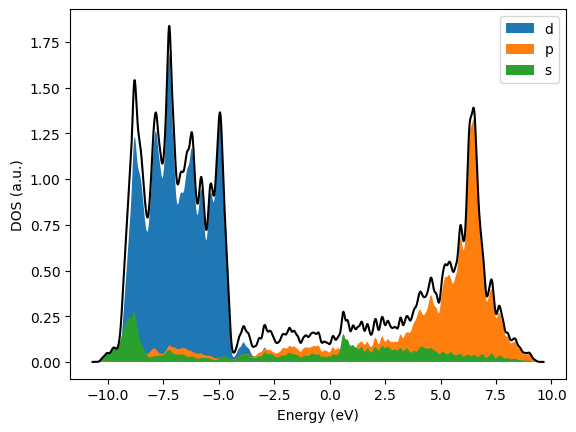

In [31]:
import numpy as np
import matplotlib.pyplot as plt

dos_tot=np.loadtxt("dos.dat")
dos_s=np.loadtxt("dos_s.dat")
dos_p=np.loadtxt("dos_p.dat")
dos_d=np.loadtxt("dos_d.dat")

plt.plot(dos_tot[:,0],dos_tot[:,1],color="black")
plt.fill_between(dos_d[:,0],dos_d[:,1],label="d",alpha=1.0)
plt.fill_between(dos_p[:,0],dos_p[:,1],label="p",alpha=1.0)
plt.fill_between(dos_s[:,0],dos_s[:,1],label="s",alpha=1.0)
plt.xlabel("Energy (eV)")
plt.ylabel("DOS (a.u.)")
plt.legend()
plt.show()




Why is the d- and p-bands much more narrow than the s-band?

# Band structure

For three dimensional systems we will have a three-dimensional k-space. Just like the special role of $k=0$ and $k=\frac{\pi}{a}$ in the one dimensional case, we have special k-points also in three dimensional space.

ASE provide convinient handling of k-points: https://databases.fysik.dtu.dk/ase/ase/dft/kpoints.html. We can for example ask for the names and coordinates of the special k-points relavant for our crystal.

In [32]:
lat = atoms.cell.get_bravais_lattice()
special_kpoints = lat.get_special_points()
print("Special kpoints are: ",list(special_kpoints))
print("With coordinats:")
for k in list(special_kpoints):
  print(k,":",*special_kpoints[k])

Special kpoints are:  ['G', 'K', 'L', 'U', 'W', 'X']
With coordinats:
G : 0 0 0
K : 0.375 0.375 0.75
L : 0.5 0.5 0.5
U : 0.625 0.25 0.625
W : 0.5 0.25 0.75
X : 0.5 0.0 0.5


We can generate a path between the special k-points using the `cell.bandpath()` function of ASE. Such paths constitute the x-axis of band diagrams.

In [39]:
path = atoms.cell.bandpath('GXWKG', npoints=400)
kpoints=""
counter=-1
for k in path.kpts:
  counter += 1
  kpoints += f'{k[0]} {k[1]} {k[2]} 1.0 \n' # DFTB+ input requires three coordinates + a weight

print("The last 10 lines of our k-point path look like this")
print('\n'.join(kpoints.splitlines()[-10:]))


The last 10 lines of our k-point path look like this
0.022959183673469385 0.022959183673469385 0.04591836734693877 1.0 
0.020408163265306145 0.020408163265306145 0.04081632653061229 1.0 
0.017857142857142905 0.017857142857142905 0.03571428571428581 1.0 
0.015306122448979609 0.015306122448979609 0.030612244897959218 1.0 
0.012755102040816313 0.012755102040816313 0.025510204081632626 1.0 
0.010204081632653073 0.010204081632653073 0.020408163265306145 1.0 
0.007653061224489832 0.007653061224489832 0.015306122448979664 1.0 
0.005102040816326536 0.005102040816326536 0.010204081632653073 1.0 
0.0025510204081632404 0.0025510204081632404 0.005102040816326481 1.0 
0.0 0.0 0.0 1.0 


## Preparing DFTB+ for a proper band diagram plot!
We would like to extract the crystal orbitals, and their corresponding energies (the y-values of the band diagram), belonging to the specific k-points along our choosen path.

The problem is, that in order to get a reasonably converged electron density in our SCF procedure we need to cover k-space in an even way (typically using regular grids and not lines). We therefore read the electron density from a converged simulation that use a regular grid and then simply evaluate the crystal orbital and energies at our k-points with the converged electron density being fixed. This is done by adding the two lines:

```
   ReadInitialCharges=Yes
   MaxSCCIterations = 1
```
to the `dftb_in.hsd' file. Which tells DFTB+ to read the charge density from the file `charges.bin` and to only do a single SCF step, i.e not to update the charge density. This type of calculation if often referef to as a non-SCF calculation.

We can insert our k-points path into the input file using the block `{kpoints}` as shown in the example below.

In [40]:
#NOTE! WITH FORMATED STRINGS, e.g.: f'{DATA}', THE {} ARE RESERVED FOR TAKING IN
#DATA. WE THEREFORE HAVE TO USE '{{' IF WE REALLY LIKE TO INSERT THE SYMBOL  '{'
#INTO OUR STRING. THIS IS THE CASE FOR THE EXAMPLE BELOW.

dftb_in=f'''
Geometry = GenFormat {{
    <<< "in.gen"
}}

Driver = ConjugateGradient{{
   MaxForceComponent = 0.0001
   MaxSteps = 0
   }}
Hamiltonian = DFTB{{
   KPointsAndWeights = {{
   {kpoints} # <- HERE IS WHERE WE INSERT OUR KPOINTS
   }}
   MaxAngularMomentum = {{
      Au = d
   }}
   ReadInitialCharges=Yes
   MaxSCCIterations = 1
   SCC = Yes
   SCCTolerance = 1e-08
   SlaterKosterFiles = Type2FileNames{{
      Prefix = ./auorg-1-1/
      Separator = "-"
      Suffix = ".skf"
      }}
   }}
Options {{
   WriteResultsTag = Yes
   WriteDetailedXml = Yes
}}
Analysis = {{
  WriteEigenvectors = Yes
  ProjectStates={{
    Region = {{
      Atoms = Au
      ShellResolved = Yes
      Label = "dos_Au"
    }}
  }}
}}
ParserOptions {{
   IgnoreUnprocessedNodes = Yes
}}
'''
f=open('dftb_in.hsd',"w")
print(dftb_in,file=f)
f.close()

The next few lines evalutes the crystal orbitals along our path and store the data in the file `band_tot.dat`.

In [41]:
!dftb+ > std.out
!dp_bands band.out band

Here we simply plot the crystal orbital energies along our path to complete the band diagram.



9


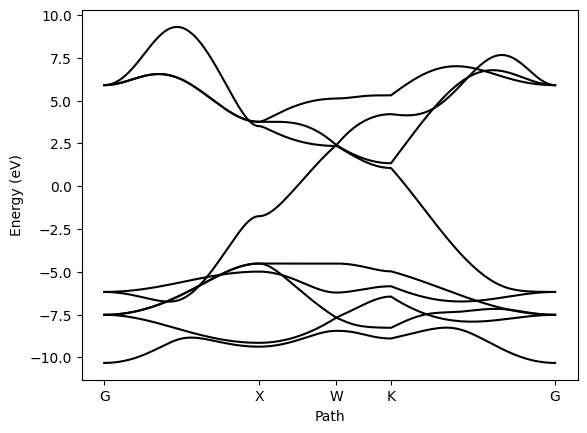

In [42]:
from ase.dft.kpoints import labels_from_kpts
x,x_special,labels= labels_from_kpts(path.kpts, atoms.cell, eps=1e-05, special_points=special_kpoints)

fig, ax = plt.subplots()

band=np.loadtxt("band_tot.dat")
n_bands=np.shape(band)[1]-1
print(n_bands)
for i in range(n_bands):
  ax.plot(x,band[:,i+1],color="black")

#Put the labels in
ax.set_xticks(x_special)
ax.set_xticklabels(labels)
ax.set_xlabel("Path")
ax.set_ylabel("Energy (eV)")
fig.show()


# You are almost an expert now!

To complete you training:

Consider an example example for TiO$_2$ provided at the 'DFTB+ recipies' page: https://dftbplus-recipes.readthedocs.io/en/latest/basics/bandstruct.html

Reproduce their results using 'our' way. That is define the structure separately as an atoms object and plot the results using the plotting tools provided in this example.

Task (Basic level): Use the caclulated band diagram to illustrate if there is a direct or indirect band-gap.

Task (Advanced level): Explore the varition in the PDOS when introducing a point-defect to the system (e.g. an oxygen vacancy). Note that you would typically need to make a supercell to avoid the defect from interacting across the periodic boundaries.